In [1]:
#from influxdb import InfluxDBClient
import gmaps
import numpy as np
import gmaps.datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import influxdb
import requests
import impyute
from datetime import datetime as dt
from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [2]:
auth = pd.read_json('../auth.json',typ='series')
client = influxdb.DataFrameClient(auth.influxdb['hostname'], 8086, ssl=True, username=auth.influxdb['username'], password=auth.influxdb['password'])

# set up pm data

In [3]:
coords = client.query("select * from coords", database="sensenet_coords")
userData = coords['coords']
userData = userData.reset_index(drop=True)
userData=userData.rename(columns={"box":"dev_id"})
userData.dev_id=[(int)(x.split('x')[-1]) for x in userData.dev_id]
userData

,dev_id,latitude,longitude,type,uid
0,11,38.029883,-78.484047,outdoor,LF
1,10,38.030613,-78.479057,outdoor,CCI
2,9,38.025759,-78.469295,outdoor,Jon K.
3,8,38.047450,-78.483030,outdoor,Angela O.
4,7,38.025570,-78.516610,outdoor,Lane R.
5,6,38.025092,-78.503586,outdoor,Jimmy H.
6,5,38.045801,-78.503947,outdoor,Francis R.
7,4,38.027580,-78.515191,outdoor,Alex N.
8,3,38.024780,-78.484580,outdoor,Lucas A.
9,2,38.065460,-78.495820,outdoor,Zihao Z.


In [4]:
complete_df = client.query("select * from \"sensenet-test\"", database="sensornet_db")
pmData = complete_df['sensenet-test']
pmData[['dev_id','pm25', 'pm10', 'co2', 'temp', 'humidity', 'gtw_id', 'rssi', 'snr']].head()
#sbox2 has basically no data
boxes = ['sbox'+str(i) for i in range(3,12)]
pmData = pmData[pmData.dev_id.isin(boxes)]
pmData.dev_id=[(int)(x.split('x')[-1]) for x in pmData.dev_id]
pmData=pmData.join(userData,on='dev_id',rsuffix='_user',how="outer")
pmData=pmData.reset_index()
pmData=pmData.rename(columns={"index":"time"})
pmData.head()

,time,airtime,channel,co2,data_rate,dev_id,frequency,gtw_id,humidity,latitude,...,pm25,rssi,snr,temp,timestamp,dev_id_user,latitude_user,longitude_user,type,uid
0,2020-02-03 00:36:03.779007152+00:00,61696000.0,3.0,144.0,SF7BW125,6,904.5,sds-gateway-3,62.89,38.026337,...,0.0,-14.0,9.00,12.52,4.366491e+08,5.0,38.045801,-78.503947,outdoor,Francis R.
1,2020-02-03 00:51:03.804609070+00:00,61696000.0,7.0,140.0,SF7BW125,6,905.3,sds-gateway-3,62.82,38.026337,...,0.0,-15.0,9.00,12.82,1.336640e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
2,2020-02-03 01:06:04.829307469+00:00,61696000.0,5.0,149.0,SF7BW125,6,904.9,sds-gateway-3,62.14,38.026337,...,0.0,-15.0,10.75,13.17,2.237630e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
3,2020-02-03 01:21:03.771676500+00:00,61696000.0,4.0,144.0,SF7BW125,6,904.7,sds-gateway-3,61.29,38.026337,...,0.0,-16.0,10.00,13.51,3.136621e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
4,2020-02-03 01:36:03.768423914+00:00,61696000.0,5.0,132.0,SF7BW125,6,904.9,sds-gateway-3,60.77,38.026337,...,0.0,-13.0,10.50,13.63,4.036612e+09,5.0,38.045801,-78.503947,outdoor,Francis R.


In [5]:
pmData['strTime'] = pmData['time']

In [6]:
for i in range(len(pmData["time"])):
    pmData['strTime'][i] = str(pmData['time'][i])

In [7]:
pmData['fdt'] = pmData['time']

In [10]:
for i in range(len(pmData["strTime"])):
    try:
        pmData['fdt'][i] = dt.strptime(pmData['strTime'][i][0:19], '%Y-%m-%d %H:%M:%S')
    except:
        pmData['fdt'][i] = pd.NaT

In [90]:
pm = pmData[['co2','pm25','pm10','temp','humidity','latitude','longitude','dev_id','fdt']]

In [265]:
def rmRepeatedConsts(frame,cols,sensitivity):
    prev_cts = {x:0 for x in cols}
    prev = {x:0 for x in cols}
    for i, row in frame.iterrows():
        for key in prev_cts.keys():
            if prev_cts[key]>=sensitivity and row[key]==prev[key]:
                frame.at[i,key] = np.NaN
            elif row[key]==prev[key]:
                prev_cts[key]+=1
            else:
                prev_cts[key]=0
            prev[key]=row[key]
    return frame

def rmRepeatedZeros(frame,cols,sensitivity):
    prev_cts = {x:0 for x in cols}
    for i, row in frame.iterrows():
        for key in prev_cts.keys():
            if prev_cts[key]>=sensitivity and row[key]==0:
                frame.at[i,key] = np.NaN
            elif row[key]==0:
                prev_cts[key]+=1
            else:
                prev_cts[key]=0
    return frame

def rmOutsideRanges(frame,cols,ranges):
    for i, row in frame.iterrows():
        for feature in cols:
            if (row[feature]<ranges[feature][0]) or (row[feature]>ranges[feature][1]):
                frame.at[i,feature] = np.NaN
    return frame

def rmOutliers(frame,sensitivity):
    boxes=[3,4,5,6,7,8,9,10,11]
    features = ["co2","pm25","pm10","temp","humidity"]
    acceptable_ranges={"co2":[0,2000],"pm25":[0,40],"pm10":[0,40],"temp":[0,41],"humidity":[0,100]}
    box_frames=[]
    for box in boxes:
        box_frame = frame[frame.dev_id == box]
        box_frame = rmRepeatedConsts(box_frame,features,sensitivity)
        box_frame = rmRepeatedZeros(box_frame,features,sensitivity)
        box_frame = rmOutsideRanges(box_frame,features,acceptable_ranges)
        box_frames.append(box_frame)
    return pd.concat(box_frames, ignore_index=True)

In [264]:
pm_na = rmOutliers(pm,3)

In [278]:
pm_na

,co2,pm25,pm10,temp,humidity,latitude,longitude,dev_id,fdt
0,1247.0,NaN,NaN,19.29,37.97,38.030388,-78.484,3,2020-02-03 00:40:39
1,1131.0,NaN,NaN,19.33,38.34,38.030388,-78.484,3,2020-02-03 00:55:39
2,1131.0,NaN,NaN,20.40,37.63,38.030388,-78.484,3,2020-02-03 01:10:39
3,786.0,23.0,23.0,22.84,35.00,38.030388,-78.484,3,2020-02-03 01:37:25
4,785.0,30.0,33.0,22.94,35.39,38.030388,-78.484,3,2020-02-03 01:52:25
...,...,...,...,...,...,...,...,...,...
14163,418.0,1.0,1.0,32.54,33.15,NaN,NaN,11,2020-02-27 14:17:51
14164,415.0,2.0,2.0,32.60,33.69,NaN,NaN,11,2020-02-27 14:32:51
14165,383.0,1.0,1.0,31.91,33.61,NaN,NaN,11,2020-02-27 14:47:51
14166,387.0,1.0,1.0,32.43,34.14,NaN,NaN,11,2020-02-27 15:02:51


In [279]:
#could use this to linearly interpolate for the ARIMA method that Jon mentioned
pm_na.interpolate()

,co2,pm25,pm10,temp,humidity,latitude,longitude,dev_id,fdt
0,1247.0,NaN,NaN,19.29,37.97,38.030388,-78.484,3,2020-02-03 00:40:39
1,1131.0,NaN,NaN,19.33,38.34,38.030388,-78.484,3,2020-02-03 00:55:39
2,1131.0,NaN,NaN,20.40,37.63,38.030388,-78.484,3,2020-02-03 01:10:39
3,786.0,23.0,23.0,22.84,35.00,38.030388,-78.484,3,2020-02-03 01:37:25
4,785.0,30.0,33.0,22.94,35.39,38.030388,-78.484,3,2020-02-03 01:52:25
...,...,...,...,...,...,...,...,...,...
14163,418.0,1.0,1.0,32.54,33.15,38.030388,-78.484,11,2020-02-27 14:17:51
14164,415.0,2.0,2.0,32.60,33.69,38.030388,-78.484,11,2020-02-27 14:32:51
14165,383.0,1.0,1.0,31.91,33.61,38.030388,-78.484,11,2020-02-27 14:47:51
14166,387.0,1.0,1.0,32.43,34.14,38.030388,-78.484,11,2020-02-27 15:02:51


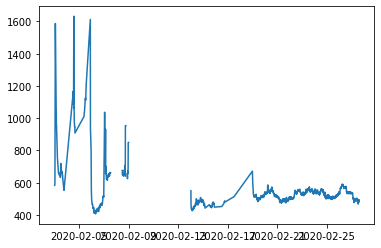

In [286]:
plt.plot(pm_na[pm_na.dev_id==7]['fdt'],pm_na[pm_na.dev_id==7]['co2'])

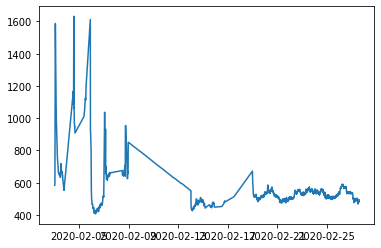

In [285]:
plt.plot(pm_na[pm_na.dev_id==7]['fdt'],pm_na[pm_na.dev_id==7]['co2'].interpolate())

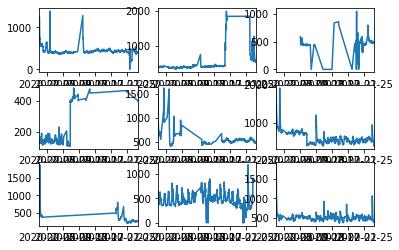

In [276]:
#co2 plots after making missing values into NaNs for boxes 3:11
#using df.interpolate() to fill NAs with linearly-interpolated values
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(pm_na[pm_na.dev_id==i+3]['fdt'],pm_na[pm_na.dev_id==i+3]['co2'].interpolate())
    plt.xlim(start_date,end_date)
    plt.axis(option=False)

In [287]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Jime\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Jime\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


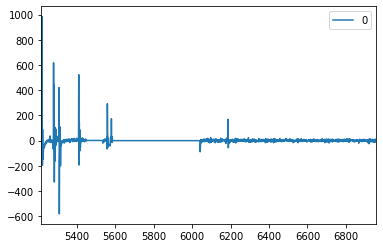

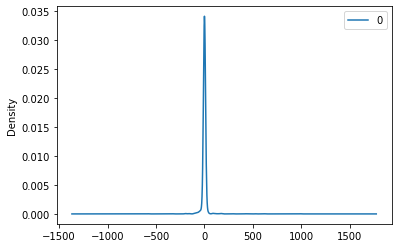

In [323]:
#https://stackoverflow.com/questions/14016247/find-integer-index-of-rows-with-nan-in-pandas-dataframe
series = pm_na[pm_na.dev_id==7]['co2'].interpolate()
inds = np.where(pm_na[pm_na.dev_id==7]['co2'].isnull())[0]
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
#print(residuals.describe())

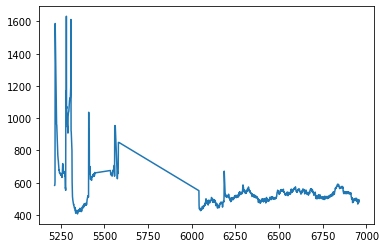

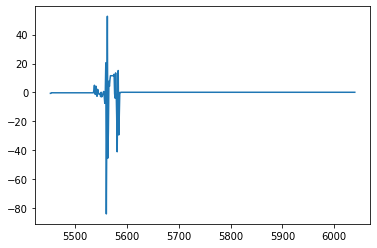

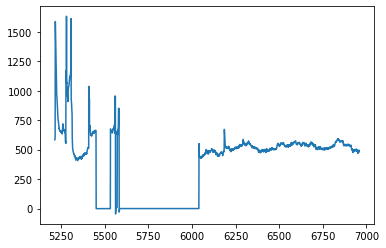

In [324]:
#attempt at replacing missing values with arima prediction (doesn't work so great yet)\
plt.figure()
plt.plot(series)
replacements=model_fit.predict(start=inds[0],end=inds[-1])
for ind in inds:
    ind+=series.index[0]
    series[ind]=replacements[ind]
plt.figure()
plt.plot(replacements)
plt.figure()
plt.plot(series)

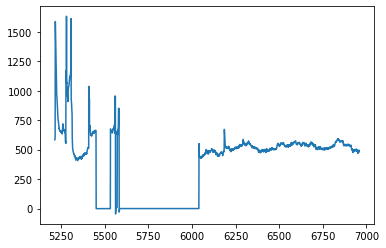

In [316]:
plt.plot(series)

# set up weather data

In [83]:
pwsIDs = [105, 171, 111, 136, 112, 80, 106, 176, 134, 8]

In [84]:
geo = pd.read_csv('../data/geo.csv')

In [85]:
weatherData = pd.read_csv("../data/2020-01-01,2020-02-22.csv")

In [86]:
weatherData=weatherData.join(geo.set_index('pws'),on="pws")

In [87]:
weatherData['DateTime']=[dt.strptime(x,'%Y-%m-%d %I:%M %p') for x in (weatherData.date + " " + weatherData.Time)]

In [88]:
weatherData.head()

,Unnamed: 0,Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,...,UV,Solar,date,pws,lat,lat_dir,long,long_dir,elevation,DateTime
0,1,12:04 AM,41.5 F,27.5 F,57 %,NE,0.0 mph,0.0 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:04:00
1,2,12:09 AM,41.5 F,27.5 F,57 %,NE,0.0 mph,0.0 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:09:00
2,3,12:14 AM,41.4 F,27.6 F,58 %,ESE,0.1 mph,0.2 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:14:00
3,4,12:19 AM,41.2 F,27.9 F,59 %,SE,0.0 mph,0.2 mph,29.20 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:19:00
4,5,12:24 AM,41.0 F,27.9 F,59 %,SE,0.0 mph,0.0 mph,29.20 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:24:00


# Data Imputation
## pm2.5: Non-homogeneous Poisson process

In [89]:
pmData[pmData.dev_id==3].co2

5041    1247.0
5042    1131.0
5043    1131.0
5044     786.0
5045     785.0
         ...  
7076     456.0
7077     454.0
7078     457.0
7079     450.0
7080     450.0
Name: co2, Length: 2040, dtype: float64

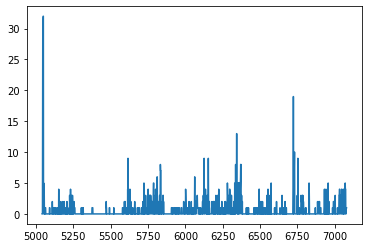

In [90]:
plt.plot(pmData[pmData.dev_id==3].pm25)

## pm10: Non-homogeneous Poisson process

# make dataframe for predictions
## for each of PM2.5,PM10,C02 there is a dataframe where each row contains:
- response variable = one of the 10 AQ stations
- features:
    - the other 9 AQ station features and their distances to the response station
    - all 10 weather station features and their distance to the response station
- one record per 5 minutes

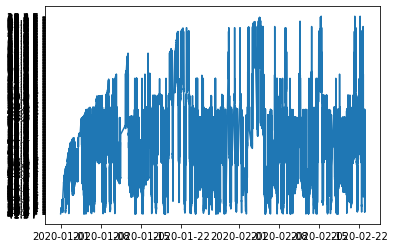

In [91]:
plt.plot(weatherData[weatherData.pws==171.0].DateTime,weatherData[weatherData.pws==171.0].Temperature)

In [92]:
gmaps.configure(api_key=auth.gmaps['api_key']) # Your Google API key

In [93]:
#weather data one reading per 5 mins
#pm data one reading per 15 mins
#must move through time and for each 5 mins get the closest data point for each weather station and each AQ station
#each row has predictors from all stations with one AQ station removed
#thus we have the same # of rows as the weather data because 1 row for each of the 10 stations is combined into 1 row
#all of the AQ data is applied, and then it is multiplied out by 10 for predicting each of the AQ stations

In [94]:
pmData=pmData.sort_values(by=['DateTime'])
weatherData=weatherData.sort_values(by=['DateTime'])